<a href="https://colab.research.google.com/github/18521509/CS114.K21.KHTN/blob/master/%C4%90%E1%BB%93_%C3%A1n_cu%E1%BB%91i_k%C3%ACL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocessing data

---



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

##Resize IMG


### Hiển thị thông tin dữ liệu

In [ ]:
import os
def Show_data_info(path = '/content/drive/My Drive/Dataset Đồ án ML/dataset'):
    sum=0
    for name in os.listdir(path):
        count = len(os.listdir(path+'/'+name))
        sum+=count
        print(name, ':', count)
    print(sum)


###Hàm thay đổi kích thước ảnh

In [ ]:
def resize_img(dir, path):
    csv_dir = os.path.join(dir,'ListIMG.csv')
    if os.path.exists(csv_dir):
        listIMG = pd.read_csv(csv_dir)
        listIMG = list(listIMG['Name'])
        print(len(listIMG))
    else: 
        listIMG = []
    img_size = 448
    import time
    folders = os.listdir(path)
    start = time.time()
    for name in folders:
        print (name)
        _dir = dir + '/' + name
        _path = path + '/' + name
        if not os.path.exists(_dir):
            #shutil.rmtree(_dir)
            os.mkdir(_dir)  

        files = os.listdir(_path)
        count = len(os.listdir(_dir))

        for img in files:
            if img not in listIMG:
                img_path = _path + '/' +img
                img_dir = _dir + '/' + name +  '_{:03}.jpg'.format(count)
                a = cv2.imread(img_path)
                a = cv2.resize(a,(img_size,img_size))
                cv2.imwrite(img_dir,a)
                count+=1
                if count % 100 == 0:
                    print(name, count,time.time()-start)
                listIMG.append(img)
    end = time.time()
    print(end-start)
    my_df = {'Name' : listIMG}
    if os.path.exists(csv_dir):
        os.remove(csv_dir)
    df = pd.DataFrame(my_df, columns= ['Name'])
    df.to_csv(csv_dir , header=True)

###Thực hiện thay đổi kích thước ảnh

In [ ]:
# #resize train data

# data_dir = '/content/drive/My Drive/My Dataset'
# data_path ='/content/drive/My Drive/Dataset Đồ án ML/dataset'
# resize_img(data_dir,data_path)

In [ ]:
#resize test data

# test_dir = '/content/drive/My Drive/My Testset'
# test_path ='/content/drive/My Drive/Dataset Đồ án ML/testset'
# rs(test_dir,test_path)

In [ ]:
# print('Train')
# Show_data_info('/content/drive/My Drive/Dataset Đồ án ML/dataset')
# print('\nTest')
# Show_data_info('/content/drive/My Drive/Dataset Đồ án ML/testset')

#Các hàm Xử lý dữ liệu


##Hàm chuyển dữ liệu sang xám

In [ ]:
def toGray(path,dir):
    image = cv2.imread('C:/Users/N/Desktop/Test.jpg')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

##Load dữ liệu (ảnh đã resize)

---




In [ ]:
def Load_data(path):
    start = time()
    folders = ['CT', 'B','C','E','D']

    imgs = []
    labels = []
    count = 0
    for folder in folders:
        for img in os.listdir(os.path.join(path,folder)):
            a = cv2.imread(os.path.join(path,folder,img))
            imgs.append(a)
            labels.append(folder)           
            count+=1
            if count%50==0:
                print(count, '{:.1f}s'.format(time()-start))
    return imgs, labels

##Detect các cạnh

In [ ]:
def Edge_detect(data):
    kernel = np.array([[1,1,1], [1,-7,1], [1,1,1]])
    new_data = []
    for img in data:
        new_data.append( cv2.filter2D(img, -1, kernel))
    from google.colab.patches import cv2_imshow
    id =  0 #@param
    return new_data


##Chuyển hệ màu BGR sang RGB

In [ ]:
def BGR2RGB(data):
    new_data = []
    for i in range(len(data)):
        new_data.append(cv2.cvtColor(data[i], cv2.COLOR_BGR2RGB))
        if (len(new_data) == 100):
            print("Convert {}".format(len(new_data)))
    return new_data

##Khai báo thư viện

In [ ]:
from google.colab.patches import cv2_imshow
import cv2, os, shutil
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from time import time
from skimage import color
from skimage.feature import hog,canny
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

#Xử lý dữ liệu

##Load dữ liệu, Detect cạnh, chuyển sang hệ màu RGB

In [ ]:
train_path =  '/content/drive/My Drive/My Dataset'
test_path = '/content/drive/My Drive/My Testset'
train_imgs, train_labels = Load_data(train_path)
print('Train data.')
test_imgs, test_labels = Load_data(test_path)
print('Test data.')

_train_imgs = Edge_detect(train_imgs)
_test_imgs = Edge_detect(test_imgs)

train_data = BGR2RGB(_train_imgs)
test_data = BGR2RGB(_test_imgs)

print('Finish')

###Hiển thị ảnh train

C


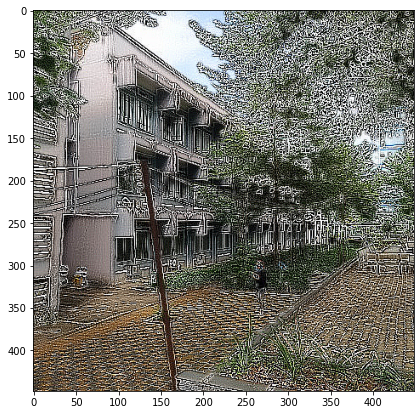

In [ ]:
plt.figure(figsize = (7,7))
id_train =  600#@param
print(train_labels[id_train])
plt.imshow(train_data[id_train])

###Hiển thị ảnh test

D


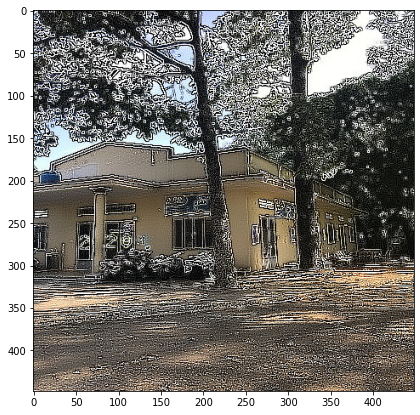

In [ ]:
plt.figure(figsize = (7,7))
id_test =  400#@param
print(test_labels[id_test])
plt.imshow(test_data[id_test])

##HOG Features

##Chuyển sang ảnh xám

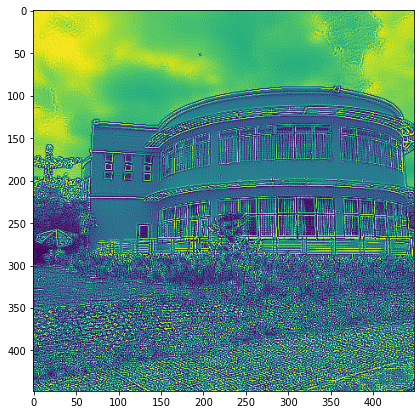

In [ ]:
train_data_gray = [ color.rgb2gray(i) for i in train_data]
test_data_gray = [ color.rgb2gray(i) for i in test_data]
plt.figure(figsize = (7,7))
plt.imshow(train_data_gray[51])

##Sử dụng Hog features

In [ ]:
def hog_feature(data_gray):
    ppc = 16
    hog_images = []
    hog_features = []
    for image in data_gray:
        fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
        hog_images.append(hog_image)
        hog_features.append(fd)
    return hog_images, hog_features

##Chuẩn bị dữ liệu cho training

In [ ]:
train_hog_images, train_hog_features = hog_feature(train_data_gray)
test_hog_images, test_hog_features = hog_feature(test_data_gray) 

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

x_train = np.array(train_hog_features)
x_test = np.array(test_hog_features)

x_train.reshape(-1,1)
x_test.reshape(-1,1)

array([[0.04654028],
       [0.03163539],
       [0.03718966],
       ...,
       [0.05537398],
       [0.04082778],
       [0.02847709]])

#Training

### Support Vector classification

In [ ]:
clf = svm.SVC()
clf.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
print(clf.score(x_train,y_train))
print(clf.score(x_test,y_test))

0.9753649635036497
0.5683297180043384


### Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test) )

1.0
0.5097613882863341


###Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
print(gnb.score(x_train, y_train))
print(gnb.score(x_test, y_test))

0.8357664233576643
0.5748373101952278


#Predict

In [ ]:
import pickle
models_path = '/content/drive/My Drive/Model ML'

pickle.dump(gnb, open(models_path+'/'+'GNB1.sav', 'wb'))

pickle.dump(clf, open(models_path+'/'+'SVM1.sav', 'wb'))

pickle.dump(rfc, open(models_path+'/'+'RFC1.sav', 'wb'))

In [ ]:
def predict(model, data):
    for i in range(len(data)):
        data[i] = cv2.resize(data[i],(448,448))
    data = Edge_detect(data)
    data = BGR2RGB(data)
    gray_data = [color.rgb2gray(i) for i in data]
    _, hog_features = hog_feature(gray_data)
    x_train = np.array(hog_features)
    x_train.reshape(-1,1)
    return model.predict(x_train)

In [ ]:
print(predict(gnb,test_imgs[0:10]))

['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E']



#Nhận xét
---
Các model bị overfitting, nguyên nhân do bộ dữ liệu quá nhỏ. (1200 ảnh cho 5 lớp)

Model Gaussian Naive Bayes ít bị overfitting nhất.

Độ chính xác chưa cao do bị nhiễu (cây cối), toà nhà B và E ở một số góc chụp giống nhau
